In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
import os
from scipy.io import wavfile
import sounddevice as sd
from scipy.signal import freqz
from pydio import *
import soundfile as sf
from scipy import signal



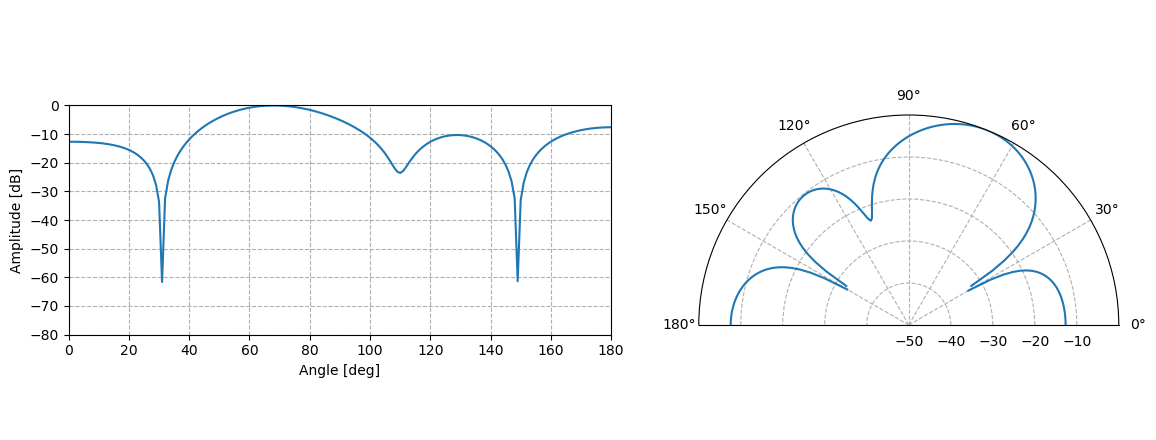

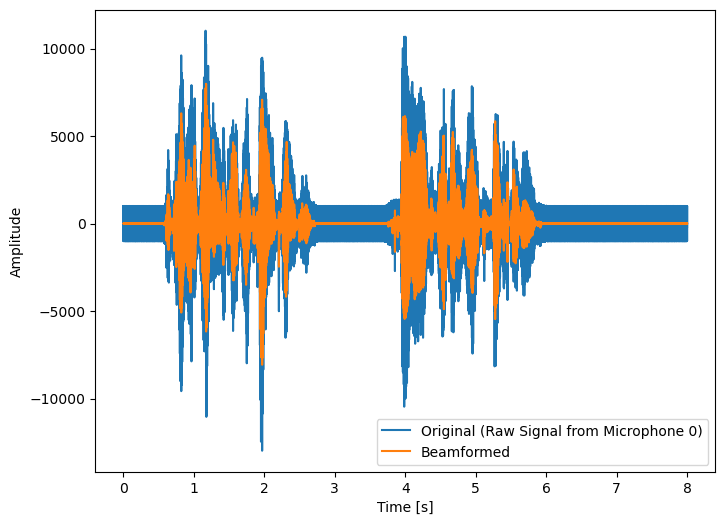

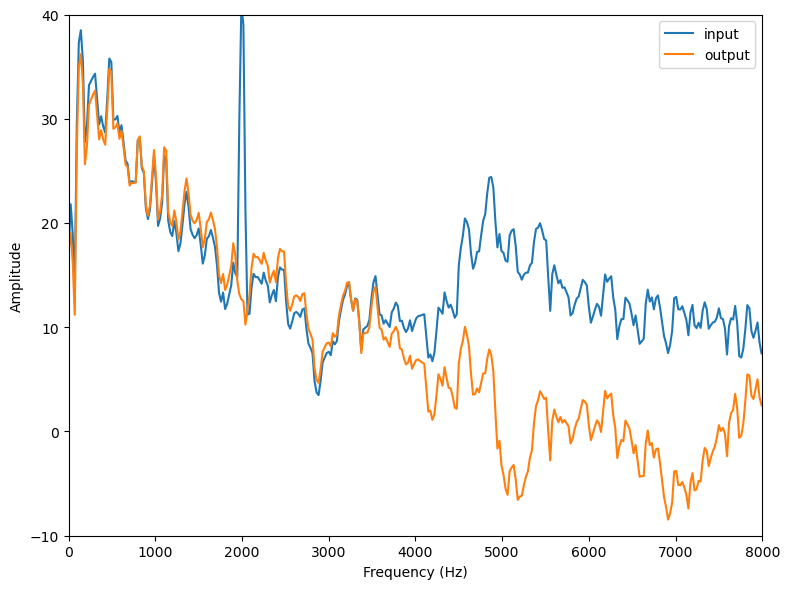

In [35]:
## Theoretical
N = 8                       # Number of microphones elements
sensor_spacing = 0.05       # Spacing between microphones (in meters)
c = 343                     # speed of sound (m/s)
freqency_noise = 2000       # in Hz
desired_angle = 70          # Degrees
interference_angles = 150   # Degrees

array_geometry = np.arange(N) * sensor_spacing
lamba = c/freqency_noise

theta = np.linspace(0, np.pi, 181)  # Steering angles

# steering vectors for each angle and sensor
steering_vectors = np.exp(-1j * 2 * np.pi/lamba * np.outer(array_geometry, np.cos(theta)))

# Desired steering vector
desired_angle_rad = np.deg2rad(desired_angle)
desired_steering_vector = np.exp(-1j * 2 * np.pi * array_geometry/lamba * np.cos(desired_angle_rad))


samplerate, tx = wavfile.read('data/P501_C_english_m1_FB_48k.wav')
datalenght = len(tx)

# simulation 
t = np.arange(datalenght)/samplerate
noise = 1000 * np.sin(2 * np.pi * freqency_noise * t)

# simulate the time of arrival
r_noise = collectPlaneWave(N, sensor_spacing, interference_angles, noise, samplerate)
r = collectPlaneWave(N, sensor_spacing, desired_angle, tx, samplerate)

r = r + r_noise #sum the simulated noise and source signal

# Calculate the MVDR weights
R_inv = np.linalg.inv(np.cov(r_noise))  # Covariance matrix
num = np.dot(R_inv, desired_steering_vector.T)
deno =  (np.dot(desired_steering_vector.conj(), np.dot(R_inv, desired_steering_vector.T)))
w = num / deno
#w = np.flip(w)

w = w / np.linalg.norm(w)


# Calculate the MVDR beam pattern
mvdr_beam_pattern = np.abs(np.dot(np.flip(w.conj().T), steering_vectors)).T

# plot beampattern
plot_combi(np.rad2deg(theta), 20 * np.log10(mvdr_beam_pattern / np.max(mvdr_beam_pattern)), 'MVDR_beampattern_sim')

# filter the input signals
output_signal = np.dot(w,r)

# plot signals
plt.figure(figsize=(8, 6))
time_in_seconds = np.arange(len(output_signal)) / samplerate
plt.plot(time_in_seconds, r[0], label='Original (Raw Signal from Microphone 0)')
plt.plot(time_in_seconds, output_signal, label='Beamformed')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# spectral density estimation
freq, fft = signal.welch(tx, fs=samplerate, nperseg=1024*2)
freq_input, fft_input = signal.welch(r[0].squeeze().real, fs=samplerate, nperseg=1024*2)
freq_output, fft_output = signal.welch(output_signal, fs=samplerate, nperseg=1024*2)

# plot spectrum
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(freq_input, 10*np.log10(fft_input), label='input')
ax1.plot(freq_output, 10*np.log10(fft_output), label='output')
plt.legend()
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude')
plt.xlim(0, 8000)
plt.ylim(-10,40)
fig.tight_layout()
plt.show()

In [25]:
20*np.log10(np.sqrt(np.mean(output_signal[0:1000].real**2))/np.sqrt(np.mean(r[0,0:1000]**2)))
sd.play(output_signal.astype(np.int16), samplerate)
#sd.play(r[0].astype(np.int16), samplerate)

C:\Users\simon\AppData\Local\Temp\ipykernel_10000\899266827.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  sd.play(output_signal.astype(np.int16), samplerate)


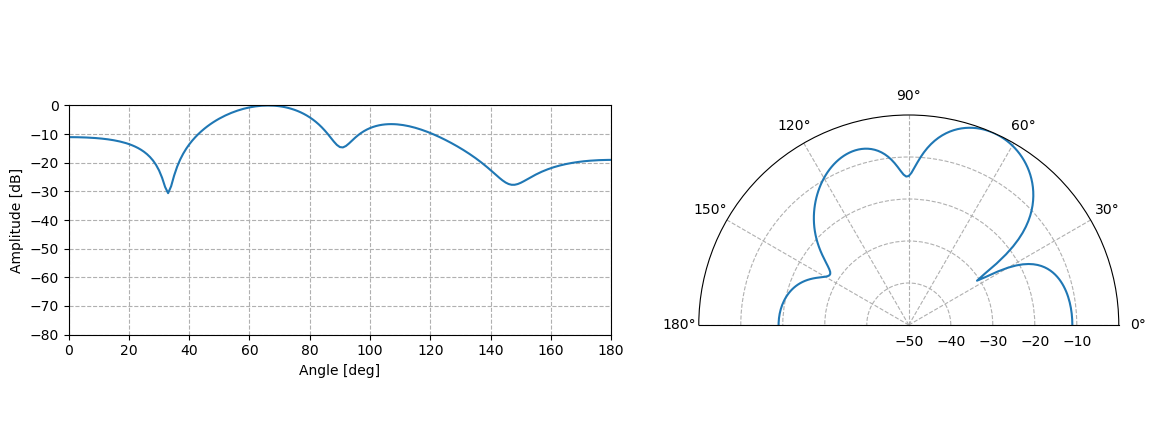

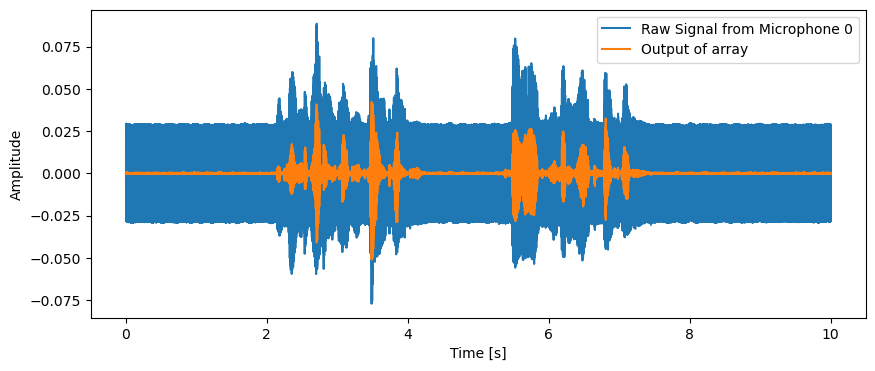

<Figure size 640x480 with 0 Axes>

In [45]:
# real life test
filePathNoise = 'data/measurement_2k_noise_high_amplitude_speach_signal/2k_noise_reference.wav'
r_noise, samplerate = sf.read(filePathNoise)
datalenght = len(r_noise)
r, samplerate = sf.read('data/measurement_2k_noise_high_amplitude_speach_signal/2k_noise__60_deg_speach_signal_20_deg.wav')

r_noise = r_noise.T
r = r.T

# calibrate the mic gains
a = equalizationCoefficients(filePathNoise)
a = a.T

for i in range(N):
    r_noise[i] = r_noise[i] * a[i]
    r[i] = r[i] * a[i]

# Calculate the MVDR weights
R_inv = np.linalg.inv(np.cov(r_noise))

num = np.dot(R_inv, desired_steering_vector.T)
deno =  (np.dot(desired_steering_vector.conj(), np.dot(R_inv, desired_steering_vector.T)))
w = num / deno
w = w / np.linalg.norm(w)

# Calculate the MVDR beam pattern
mvdr_beam_pattern = np.abs(np.dot(w.conj().T, steering_vectors)).T

# plot beampattern
plot_combi(np.rad2deg(theta), 20 * np.log10(mvdr_beam_pattern / np.max(mvdr_beam_pattern)), 'MVDR_beampattern_test')

# filter the input signals
output_signal = np.dot(w,r).real

plt.figure(figsize=(10, 4))
time_in_seconds = np.arange(len(output_signal)) / samplerate
plt.plot(time_in_seconds, np.asarray(r[0,:].T), label='Raw Signal from Microphone 0')
plt.plot(time_in_seconds, output_signal, label='Output of array')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()
plt.savefig('plots/'+ 'MVDR_signal_test' +'.svg',bbox_inches='tight', pad_inches=0)

In [48]:
20*np.log10(np.sqrt(np.mean(output_signal[0:1000]**2))/np.sqrt(np.mean(r[0,0:1000]**2)))
sd.play(output_signal, samplerate)